In [42]:
import pandas as pd
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures

In [2]:
file = '/Users/kiening/Documents/Dissertation/dissertation.cb_companies.json'

with open(file, 'r', encoding='utf-8') as file:
    data = json.load(file)


In [3]:
def whether_success(data):
    for i in data:
        i['startup'] = 'failed'
        if i['operating_status'] != 'closed':
            if i['went_public_on']:
                i['startup'] = 'success'
            elif i['status'] == 'was_acquired' or i['status'] == 'ipo':
                i['startup'] = 'success'
            elif (datetime.now() - datetime.strptime(i['founded_on'], '%Y-%m-%d')).days/365 >= 7:
                i['startup'] = 'success'
            elif i['num_funding_rounds'] >= 7:
                i['startup'] = 'success'
            elif i['equity_funding_total_usd'] >= 100000000:
                i['startup'] = 'success'
    return data

In [4]:
def build_nw(comps, peo):
    G = nx.Graph()
    G.add_nodes_from(comps)
    
    peo_dict = {comp: set(p) for comp, p in zip(comps, peo)}
    
    def process_pairs(i, comp):
        edges = []
        for j in range(i+1, len(comps)):
            same = peo_dict[comp] & peo_dict[comps[j]]
            if same:
                edges.append((comp, comps[j], len(same)))
        return edges

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_pairs, i, comp) for i, comp in enumerate(comps)]
        for future in as_completed(futures):
            for comp1, comp2, weight in future.result():
                if G.has_edge(comp1, comp2):
                    G[comp1][comp2]['weight'] += weight
                else:
                    G.add_edge(comp1, comp2, weight=weight)

    return G


In [29]:
def data_pre(data):
    for i in data:
        if 'metadata' in i.keys():
            del i['metadata']
        if not isinstance(i['equity_funding_total_usd'], int):
            value = i['equity_funding_total_usd']
            i['equity_funding_total_usd'] = int(value['$numberLong'])
    return data

In [30]:
data_test = data_pre(data[:10000])
data_test = whether_success(data_test)

In [31]:
# Read data here
comps = []
peo = []

for com in data[:10000]:
    comps.append(com['name'])
    peo.append(list(set(com['founders']) | set(com['investors'])))

unique_comps = [f"{comp}_{i}" for i, comp in enumerate(comps)]

In [7]:
len(comps)

10000

In [11]:
for i in range(len(data_test)):
    if data_test[i]['status'] == 'was_acquired' and not data_test[i]['investors']:
        print(i)

852
1680
1711
1970
2239
2769
2932
3044
4141
4319
4438
4453
4583
4840
5143
5367
5507
5590
6489
6515
6652
7539
8047
8532
8684
8929
8971
9162
9299
9641


In [12]:
data_test[4453]

{'_id': {'$oid': '667d632d73f74a2b87f0eb1e'},
 'uuid': 'e8ec8797-32d4-40ff-889e-e9144427d949',
 'categories': ['Banking',
  'FinTech',
  'Information Technology',
  'Venture Capital'],
 'category_groups': ['Financial Services',
  'Information Technology',
  'Lending and Investments'],
 'cb_created_at': '2018-06-11T17:46:09Z',
 'cb_updated_at': '2024-06-10T12:46:08Z',
 'created_at': {'$date': '2024-06-27T14:03:41.670Z'},
 'equity_funding_total_usd': 60000000,
 'facet_ids': ['investor', 'company', 'rank'],
 'founded_on': '2017-01-01',
 'founders': ['Shiliang Tang'],
 'funding_stage': 'm_and_a',
 'funding_total_usd': 60000000,
 'investor_stage': ['early_stage_venture', 'seed', 'venture'],
 'investors': [],
 'last_equity_funding_total_usd': 60000000,
 'last_equity_funding_type': 'series_unknown',
 'last_funding_date': '2019-03-07',
 'last_funding_total_usd': 60000000,
 'last_funding_type': 'series_unknown',
 'location_groups': ['Greater Miami Area', 'East Coast', 'Southern US'],
 'location

In [13]:
G = build_nw(unique_comps, peo)

In [14]:
isolates = list(nx.isolates(G))
isolates

['IXX.com_755',
 'Teleperformance Group_791',
 'IDVerse - An OCR Labs Company_797',
 'Beamer_811',
 'STACK Infrastructure_852',
 'Fortive_880',
 'PrizePicks_932',
 'Marigold_1018',
 'Verra Mobility_1059',
 'Shryne Group_1240',
 'Zap Solutions_1295',
 'Corteva Agriscience_1455',
 'Purple_1511',
 'SimSpace_1543',
 'Clarios_1680',
 'Azerion_1681',
 'Tianyancha_1694',
 'Blue Current_1711',
 'Pyypl_1826',
 'Phoenix Capital Group_1843',
 'Avride_1908',
 'Two Six Technologies_1970',
 'Lumentum_1990',
 'Fanatiz_2085',
 'BLUETTI_2100',
 'Revolution_2142',
 'Future Planet Capital_2143',
 'Snoonu_2197',
 'SwissBorg_2214',
 'PLLAY Labs_2236',
 'Covestro_2239',
 'Agilon Health_2257',
 'Agora Data_2264',
 'Autotech Ventures_2282',
 'Augmentum Fintech_2361',
 'NAX Group_2420',
 'stc pay_2496',
 'Global Ventures_2559',
 'Alpian_2560',
 'Qorvo_2578',
 'Draup_2579',
 'Gridmatic_2608',
 'Binary Defense_2634',
 'InterWell Health_2644',
 'Sol de Janeiro_2769',
 'Cardone Capital_2807',
 'Trulieve_2901',
 'G

In [36]:
len(isolates)

553

In [32]:
iso_comps = []
found_on = []
funding = []
rounds = []
startup = []
for i in range(len(unique_comps)):
    if unique_comps[i] in isolates:
        iso_comps.append(data_test[i]['name'])
        found_on.append((datetime.now() - datetime.strptime(data_test[i]['founded_on'], '%Y-%m-%d')).days)
        funding.append(data_test[i]['equity_funding_total_usd'])
        rounds.append(data_test[i]['num_funding_rounds'])
        startup.append(data_test[i]['startup'])
iso_df = pd.DataFrame({
    'company': iso_comps,
    'days_since_founded': found_on,
    'equity_funding_total_usd': funding,
    'num_funding_rounds': rounds,
    'startup': startup
})
iso_df['num_funding_rounds'] = iso_df['num_funding_rounds'].fillna(0)

In [33]:
iso_df

,company,days_since_founded,equity_funding_total_usd,num_funding_rounds,startup
0,IXX.com,2393,5000000,1.0,failed
1,Teleperformance Group,2393,0,1.0,success
2,IDVerse - An OCR Labs Company,3854,45000000,2.0,success
3,Beamer,2546,20226471,2.0,failed
4,STACK Infrastructure,2028,0,8.0,success
...,...,...,...,...,...
548,Andean Telecom Partners (ATP),3294,0,3.0,success
549,Hyer,2393,10115219,1.0,failed
550,Vår Energi,2393,0,5.0,success
551,GreenMobility,3124,35149230,6.0,success


In [52]:
print(iso_df.describe())

       days_since_founded  equity_funding_total_usd  num_funding_rounds
count          553.000000              5.530000e+02          553.000000
mean          2869.698011              4.793012e+07            2.663653
std            628.454595              1.196382e+08            2.088373
min           1683.000000              0.000000e+00            0.000000
25%           2393.000000              4.400000e+06            1.000000
50%           2758.000000              1.518672e+07            2.000000
75%           3489.000000              4.382106e+07            3.000000
max           3854.000000              1.800000e+09           17.000000


In [87]:
# Use Random forests to judge feature importance
X = iso_df.drop(columns=['startup', 'company'])
y = iso_df['startup']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalized
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Feature importance
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Rank
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                    Feature  Importance
0        days_since_founded    0.688302
1  equity_funding_total_usd    0.250185
2        num_funding_rounds    0.061513


In [88]:
# Recursive feature elimination to judge feature importance
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=1)
rfe.fit(X_train, y_train)

# Rank
ranking = rfe.ranking_
ranking_df = pd.DataFrame({'Feature': features, 'Ranking': ranking})
ranking_df = ranking_df.sort_values(by='Ranking')
print(ranking_df)

                    Feature  Ranking
0        days_since_founded        1
1  equity_funding_total_usd        2
2        num_funding_rounds        3


In [89]:
# MI to judge feature importance
mi = mutual_info_classif(X_train, y_train)

# Rank
mi_df = pd.DataFrame({'Feature': features, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)

                    Feature  Mutual Information
0        days_since_founded            0.359374
1  equity_funding_total_usd            0.073000
2        num_funding_rounds            0.013292


In [90]:
# Feature combination
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_poly = RandomForestClassifier(random_state=42)
model_poly.fit(X_train_poly, y_train)

# Performance
y_pred = model_poly.predict(X_test_poly)
print("Classification Report with Interaction Features:")
print(classification_report(y_test, y_pred))

Classification Report with Interaction Features:
              precision    recall  f1-score   support

      failed       0.87      0.90      0.89        30
     success       0.96      0.95      0.96        81

    accuracy                           0.94       111
   macro avg       0.92      0.93      0.92       111
weighted avg       0.94      0.94      0.94       111



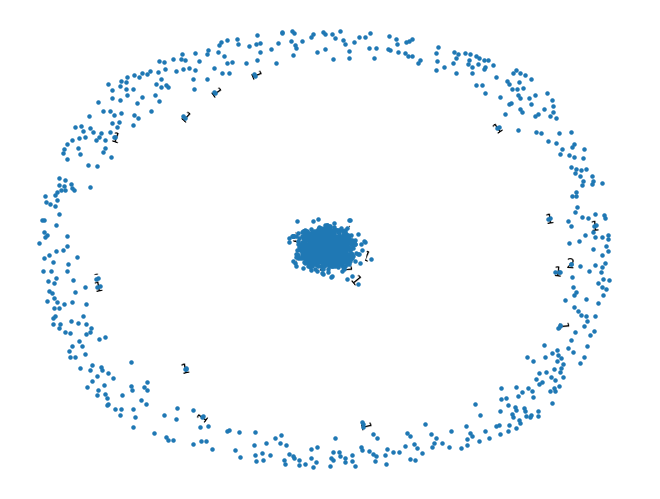

In [40]:
# Draw network here
#nx.draw(G, with_labels=True)

pos = nx.spring_layout(G)
nx.draw(G, 
        pos, 
        with_labels=False, 
        node_size=5, 
        font_size=5)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [42]:
len(G.edges)

581532

In [13]:
def generate_data(G):
    net_nodes = len(G.nodes())
    net_edges = len(G.edges())
    net_den = round(nx.density(G),4)
    avg_cluster = round(nx.average_clustering(G),4)
    avg_degree = round(np.mean(list(dict(G.degree()).values())),4)
    max_degree = max(list(dict(G.degree()).values()))
    min_degree = min(list(dict(G.degree()).values()))
    total_strength = 0
    for node in G.nodes():
        node_strength = sum(data["weight"] for u, v, data in G.edges(node, data=True))
        total_strength += node_strength
    avg_strength = round(total_strength / net_nodes, 4)
    try:
        net_assortativity = round(nx.degree_assortativity_coefficient(G),4)
    except RuntimeWarning:
        net_assortativity = None

    table ={
        "Number of Nodes": net_nodes,
        "Number of Edges": net_edges,
        "Density": net_den,
        "Avg Clustering Coefficient": avg_cluster,
        "Avg Degree": avg_degree,
        "Max Degree": max_degree,
        "Min Degree": min_degree,
        "Avg Strength": avg_strength,
        "Assortativity": net_assortativity}    
    return table

In [14]:
analysis = generate_data(G)
analysis

{'Number of Nodes': 10000,
 'Number of Edges': 581532,
 'Density': 0.0116,
 'Avg Clustering Coefficient': 0.4801,
 'Avg Degree': 116.3064,
 'Max Degree': 1104,
 'Min Degree': 0,
 'Avg Strength': 120.1728,
 'Assortativity': 0.5644}

In [3]:
data[1].keys()

dict_keys(['_id', 'uuid', 'categories', 'category_groups', 'cb_created_at', 'cb_updated_at', 'created_at', 'equity_funding_total_usd', 'facet_ids', 'founded_on', 'founders', 'funding_stage', 'funding_total_usd', 'investor_stage', 'investors', 'last_equity_funding_total_usd', 'last_equity_funding_type', 'last_funding_date', 'last_funding_total_usd', 'last_funding_type', 'location_groups', 'locations', 'name', 'num_acquisitions', 'num_employees_enum', 'num_funding_rounds', 'operating_status', 'owner', 'rank_org', 'rank_principal', 'revenue_range', 'short_description', 'status', 'updated_at', 'valuation_usd', 'version', 'exited_on', 'investor_type', 'metadata', 'went_public_on'])

In [53]:
def generate_feature(G, data):
    degrees = dict(G.degree())
    # clustering = nx.clustering(G)
    closeness = nx.closeness_centrality(G)
    #betweenness = nx.betweenness_centrality(G)
    
    nodes = list(G.nodes())
    data = {
        'node_id': nodes,
        'degree': [degrees[node] for node in nodes],
        # 'clustering': [clustering[node] for node in nodes],
        'closeness': [closeness[node] for node in nodes],
        #'betweenness': [betweenness[node] for node in nodes],
        'categories': [comp['category_groups'] for comp in data]
    }
    df = pd.DataFrame(data)
    return df

In [54]:
fea_df = generate_feature(G, data_test)

In [55]:
fea_df

,node_id,degree,closeness,categories
0,Gro Intelligence_0,118,0.379095,"[Agriculture and Farming, Artificial Intellige..."
1,Squire_1,460,0.417417,"[Apps, Commerce and Shopping, Mobile, Other, S..."
2,The EVERY Company_2,111,0.372153,"[Biotechnology, Food and Beverage, Health Care..."
3,Groq_3,442,0.415110,"[Artificial Intelligence (AI), Consumer Electr..."
4,Campus_4,75,0.361496,"[Education, Software]"
...,...,...,...,...
9995,Greenjoules_9995,2,0.246278,"[Energy, Natural Resources, Sustainability]"
9996,Vivifi India_9996,0,0.000000,[Financial Services]
9997,Deeploy_9997,10,0.274796,"[Artificial Intelligence (AI), Data and Analyt..."
9998,Pet Screening_9998,24,0.328283,"[Community and Lifestyle, Information Technolo..."


In [29]:
data_test[1]['category_groups']

['Apps', 'Commerce and Shopping', 'Mobile', 'Other', 'Software']

In [47]:
cla = {}
for i in data_test:
    for n in i['category_groups']:
        if not n in cla.keys():
            cla[n] = 1
        else:
            cla[n] += 1
cla

{'Agriculture and Farming': 226,
 'Artificial Intelligence (AI)': 1771,
 'Data and Analytics': 2426,
 'Design': 386,
 'Information Technology': 2370,
 'Science and Engineering': 2929,
 'Software': 5361,
 'Apps': 646,
 'Commerce and Shopping': 1173,
 'Mobile': 700,
 'Other': 1321,
 'Biotechnology': 937,
 'Food and Beverage': 517,
 'Health Care': 2044,
 'Manufacturing': 617,
 'Sustainability': 544,
 'Consumer Electronics': 570,
 'Hardware': 1512,
 'Education': 349,
 'Administrative Services': 464,
 'Professional Services': 770,
 'Natural Resources': 203,
 'Financial Services': 2070,
 'Government and Military': 98,
 'Payments': 683,
 'Media and Entertainment': 582,
 'Gaming': 169,
 'Sports': 243,
 'Internet Services': 1498,
 'Lending and Investments': 535,
 'Messaging and Telecommunications': 109,
 'Clothing and Apparel': 135,
 'Transportation': 1016,
 'Privacy and Security': 534,
 'Real Estate': 595,
 'Events': 66,
 'Travel and Tourism': 206,
 'Community and Lifestyle': 439,
 'Advertisin

In [14]:
ipo = 0
ac = 0
others = 0
for i in data_test:
    if i['status'] == 'was_acquired':
        ac += 1
    elif i['status'] == 'ipo':
        ipo += 1
    else:
        others += 1
print(ipo, ac, others)

441 844 8715


In [96]:
X = fea_df[fea_df['categories'].apply(lambda x: 'Software' in x)][['degree', 'closeness']]
y = [i['startup'] for i in data_test if 'Software' in i['category_groups']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [106]:
# MI to judge feature importance
features = X.columns
mi = mutual_info_classif(X_train, y_train)

# Rank
mi_df = pd.DataFrame({'Feature': features, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)

     Feature  Mutual Information
1  closeness            0.004218
0     degree            0.000000


In [97]:
X_train

,degree,closeness
2188,399,0.411619
7226,464,0.414411
9226,51,0.346864
179,273,0.401129
4585,38,0.325342
...,...,...
5510,0,0.000000
6872,86,0.353789
9660,4,0.287697
9730,24,0.303429


In [101]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_1 = LogisticRegression()
model_2 = DecisionTreeClassifier()
model_3 = RandomForestClassifier()
model_4 = SVC(kernel='linear', probability=True)
model_5 = KNeighborsClassifier(n_neighbors=3)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
model_4.fit(X_train, y_train)
model_5.fit(X_train, y_train)

y_pred_1 = model_1.predict(X_test)
y_pred_2 = model_2.predict(X_test)
y_pred_3 = model_3.predict(X_test)
y_pred_4 = model_4.predict(X_test)
y_pred_5 = model_5.predict(X_test)

model_1_poly = LogisticRegression()
model_2_poly = DecisionTreeClassifier()
model_3_poly = RandomForestClassifier()
model_4_poly = SVC(kernel='linear', probability=True)
model_5_poly = KNeighborsClassifier(n_neighbors=3)

model_1_poly.fit(X_train_poly, y_train)
model_2_poly.fit(X_train_poly, y_train)
model_3_poly.fit(X_train_poly, y_train)
model_4_poly.fit(X_train_poly, y_train)
model_5_poly.fit(X_train_poly, y_train)

y_pred_1_poly = model_1_poly.predict(X_test_poly)
y_pred_2_poly = model_2_poly.predict(X_test_poly)
y_pred_3_poly = model_3_poly.predict(X_test_poly)
y_pred_4_poly = model_4_poly.predict(X_test_poly)
y_pred_5_poly = model_5_poly.predict(X_test_poly)

In [102]:
def evaluate_pred(model, X_test, y_test, y_pred, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"{model_name} ROC AUC Score: {roc_auc:.3f}")
    else:
        print(f"{model_name} does not provide probability predictions for ROC AUC Score.")

In [105]:
evaluate_pred(model_1, X_test, y_test, y_pred_1, 'Logistic Regression')
evaluate_pred(model_2, X_test, y_test, y_pred_2, 'Decision Tree')
evaluate_pred(model_3, X_test, y_test, y_pred_3, 'Random Forest')
evaluate_pred(model_4, X_test, y_test, y_pred_4, 'SVC')
evaluate_pred(model_5, X_test, y_test, y_pred_5, 'K-Nearest Neighbors')
print('*******************************************')
evaluate_pred(model_1_poly, X_test_poly, y_test, y_pred_1_poly, 'Logistic Regression with Interaction Features')
evaluate_pred(model_2_poly, X_test_poly, y_test, y_pred_2_poly, 'Decision Tree with Interaction Features')
evaluate_pred(model_3_poly, X_test_poly, y_test, y_pred_3_poly, 'Random Forest with Interaction Features')
evaluate_pred(model_4_poly, X_test_poly, y_test, y_pred_4_poly, 'SVC with Interaction Features')
evaluate_pred(model_5_poly, X_test_poly, y_test, y_pred_5_poly, 'K-Nearest Neighbors with Interaction Features')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

      failed       0.00      0.00      0.00       339
     success       0.68      1.00      0.81       734

    accuracy                           0.68      1073
   macro avg       0.34      0.50      0.41      1073
weighted avg       0.47      0.68      0.56      1073

Logistic Regression ROC AUC Score: 0.472
Decision Tree Classification Report:
              precision    recall  f1-score   support

      failed       0.34      0.31      0.32       339
     success       0.69      0.72      0.71       734

    accuracy                           0.59      1073
   macro avg       0.52      0.52      0.52      1073
weighted avg       0.58      0.59      0.59      1073

Decision Tree ROC AUC Score: 0.528
Random Forest Classification Report:
              precision    recall  f1-score   support

      failed       0.32      0.24      0.27       339
     success       0.69      0.77      0.73 

/Users/kiening/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kiening/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kiening/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kiening/anacond